In [0]:
import numpy as np
import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf

%matplotlib inline

In [0]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

train_x = train_x.reshape(-1, 32, 32, 3).astype('float32') / 255.
test_x = test_x.reshape(-1, 32, 32, 3).astype('float32') / 255.
train_y = tf.keras.utils.to_categorical(train_y, 10) 
test_y = tf.keras.utils.to_categorical(test_y, 10)

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(10000, 32, 32, 3) float32
(50000, 10) float32
(10000, 10) float32


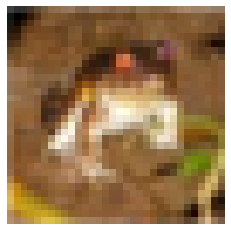

In [0]:
plt.imshow(train_x[0, :, :, :])
plt.axis('off')
plt.show()

**Создание обучающего датасета**

In [0]:
NUM_EPOCHS = 20
BATCH_SIZE = 40

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE) # skip, take

**Класс модели CNN следующей архитектуры ([отсюда](https://github.com/NovikovVN/neural_networks/blob/master/intro/neural_networks04.ipynb)):**

Первый блок генерации признаков:
 - первый свёрточный слой: 32 фильтров 3х3
 - второй свёрточный слой: 32 фильтров 3х3
 - слой пулинга через взятие максимума фильтром 2х2
 - слой дропаута для регуляризации весов

Второй блок генерации признаков:
 - третий свёрточный слой: 64 фильтров 3х3
 - четвёртый свёрточный слой: 64 фильтров 3х3
 - слой пулинга через взятие максимума фильтром 2х2
 - слой дропаута для регуляризации весов

Блок классификации:
 - два полносвязных слоя по 256 нейрона
 - слой дропаута для регуляризации весов 
 - выходной слой с 10 нейронами

In [0]:
class Model(tf.keras.Model):

    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=32,
                                            kernel_size=(3, 3),
                                            input_shape=(32, 32, 3),
                                            data_format='channels_last',
                                            activation='relu',
                                            padding='valid')
        self.conv2 = tf.keras.layers.Conv2D(filters=32,
                                            kernel_size=(3, 3),
                                            data_format='channels_last',
                                            activation='relu',
                                            padding='valid')
        self.conv3 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(3, 3),
                                            data_format='channels_last',
                                            activation='relu',
                                            padding='valid')
        self.conv4 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(3, 3),
                                            data_format='channels_last',
                                            activation='relu',
                                            padding='valid')
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(256, activation='relu')
        self.fc3 = tf.keras.layers.Dense(10, activation=None)       
        self.maxpool = tf.keras.layers.MaxPooling2D((2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(rate=0.3, seed=0)

    def call(self, inp):
        
        out = self.conv1(inp)
        out = self.conv2(out)       
        out = self.maxpool(out)
        out = self.dropout(out)        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool(out)
        out = self.dropout(out)        
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.fc3(out)

        return out

model = Model()

**Функция потерь и функция вычисления доли правильных ответов**

In [0]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                          logits=logits, labels=labels))
    
def accuracy(logits, sparsed_labels):
    predictions, labels = [tf.argmax(y, axis=1, output_type=tf.int32) \
                           for y in (logits, sparsed_labels)]
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

**Обучение модели**

In [0]:
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

writer = tf.summary.create_file_writer('logs/adam')

In [0]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)

    # Backward
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Calc and display loss/accuracy
    if iteration % 800 == 0:
        test_logits = model(test_x[:256, ...])
        accuracy_value = accuracy(test_logits, test_y[:256, ...])

        print('[%6d] Accuracy: %.2f%%' \
              % (iteration, accuracy_value.numpy()*100))

        with writer.as_default():
            tf.summary.scalar('accuracy', accuracy_value, iteration)
            tf.summary.scalar('loss', loss_value, iteration)

[     0] Accuracy: 9.38%
[   800] Accuracy: 55.08%
[  1600] Accuracy: 57.81%
[  2400] Accuracy: 66.80%
[  3200] Accuracy: 68.36%
[  4000] Accuracy: 74.22%
[  4800] Accuracy: 72.27%
[  5600] Accuracy: 74.61%
[  6400] Accuracy: 75.78%
[  7200] Accuracy: 75.00%
[  8000] Accuracy: 75.00%
[  8800] Accuracy: 78.12%
[  9600] Accuracy: 77.34%
[ 10400] Accuracy: 76.17%
[ 11200] Accuracy: 76.17%
[ 12000] Accuracy: 76.17%
[ 12800] Accuracy: 74.61%
[ 13600] Accuracy: 77.34%
[ 14400] Accuracy: 78.12%
[ 15200] Accuracy: 77.34%
[ 16000] Accuracy: 75.78%
[ 16800] Accuracy: 76.17%
[ 17600] Accuracy: 72.27%
[ 18400] Accuracy: 78.52%
[ 19200] Accuracy: 76.56%
[ 20000] Accuracy: 75.39%
[ 20800] Accuracy: 75.39%
[ 21600] Accuracy: 76.95%
[ 22400] Accuracy: 76.56%
[ 23200] Accuracy: 75.39%
[ 24000] Accuracy: 74.22%
[ 24800] Accuracy: 73.44%
CPU times: user 7min 30s, sys: 10.5 s, total: 7min 40s
Wall time: 7min 37s


**Проверка работы модели**

In [0]:
%%time

test_logits = model(test_x)
accuracy_value = accuracy(test_logits, test_y)
print('Final accuracy: %.2f%%' % (accuracy_value.numpy() * 100))

Final accuracy: 71.84%
CPU times: user 1.15 s, sys: 910 ms, total: 2.06 s
Wall time: 2.13 s


In [0]:
def test_item(sample):

    logits = model(sample[None, ...])[0]
    predictions = tf.nn.softmax(logits)
    ans = np.argmax(predictions)

    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[:, :, :])
    ax.axis('off')

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), predictions, alpha=0.5)
    bar_list[ans].set_alpha(1)
    ax.set_xticks(np.arange(10))

    plt.show()

    print(f'Predicted: {ans}')

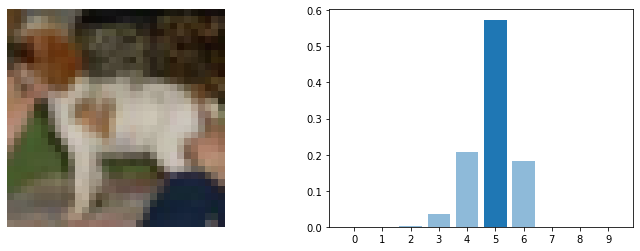

Predicted: 5
True: 5


In [0]:
idx = 12
sample = test_x[idx, ...]

test_item(sample)
print(f'True: {np.argmax(test_y[idx, ...])}')